### Zadanie 1

In [1]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

naive_multiplication (generic function with 1 method)

In [2]:
# poprawiona funkcja korzytająca z powyższego oraz z faktu, że
# można zmieniać kolejność operacji dodawania (a co za tym idzie kolejnosc petli).
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

In [3]:
using DataFrames
using Statistics

df = DataFrame(size=Int64[], multiplication_type=String[], time=Float64[])

Row,size,multiplication_type,time
,Int64,String,Float64


In [4]:
for n in 100:20:400
    A = rand([0, 1], n, n)
    B = rand([0, 1], n, n)
    naive_multiplication(A, B)
    better_multiplication(A, B)
    A * B
    for _ in 1:10
        push!(df, [n, "naive", @elapsed naive_multiplication(A, B)])
        push!(df, [n, "better", @elapsed better_multiplication(A, B)])
        push!(df, [n, "BLAS", @elapsed A * B])
    end
end

In [5]:
df = groupby(df, [:size, :multiplication_type])
df = combine(df, :time => mean, :time => std)

Row,size,multiplication_type,time_mean,time_std
,Int64,String,Float64,Float64
1,100,naive,0.00280082,4.80455e-5
2,100,better,0.00134363,0.000679431
3,100,BLAS,0.000577325,1.8184e-5
4,120,naive,0.00497564,8.46804e-5
5,120,better,0.00208064,0.00115146
6,120,BLAS,0.00103368,1.63161e-5
7,140,naive,0.00807197,0.000322438
8,140,better,0.00220521,8.54061e-5
9,140,BLAS,0.00166186,4.475e-5


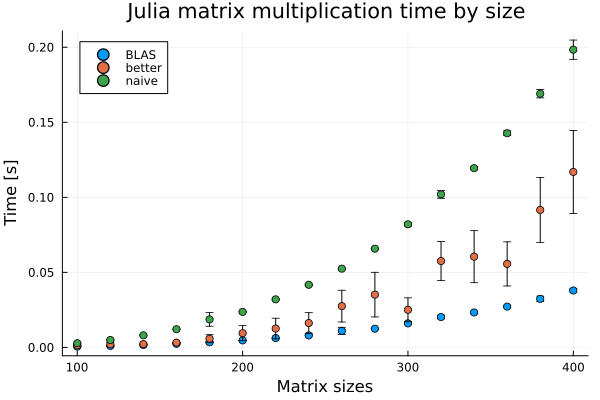

In [6]:
using StatsPlots
using Plots
julia_plot = @df df scatter(:size, :time_mean, group=:multiplication_type, yerr=:time_std, title = "Julia matrix multiplication time by size", ylabel="Time [s]", xlabel="Matrix sizes")

### Zadanie 2

```c
#include <stdio.h>
#include <gsl/gsl_blas.h>
#include <time.h>

void naive_multiplication(const double a[], const double b[], double c[], int n) {
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            for (int k = 1; k < n; k++) {
                c[j * n + i] = c[j * n + i] + a[i * n + k] * b[k * n + j];
            }
        }
    }
}

void better_multiplication(const double a[], const double b[], double c[], int n) {
    for (int j = 0; j < n; j++) {
        for (int k = 1; k < n; k++) {
            for (int i = 0; i < n; i++) {
                    c[j * n + i] = c[j * n + i] + a[i * n + k] * b[k * n + j];
            }
        }
    }
}


int main() {
    FILE* csv_file;
    csv_file = fopen("cresults.csv", "w+");
    fprintf(csv_file, "size,multiplication_type,time\n");

    double a[160000];
    double b[160000];
    double c[160000];

    clock_t t;

    for (int i = 0; i < 160000; i++) {
        a[i] = (double) rand() / RAND_MAX;
        b[i] = (double) rand() / RAND_MAX;
    }

    for (int n = 100; n <= 400; n += 20) {
        for (int i = 0; i < 10; i++) {

            t = clock();
            naive_multiplication(a, b, c, n);
            t = clock() - t;
            fprintf(csv_file, "%d,naive,%f\n", n, ((double) t) / CLOCKS_PER_SEC);

            t = clock();
            better_multiplication(a, b, c, n);
            t = clock() - t;
            fprintf(csv_file, "%d,better,%f\n", n, ((double) t) / CLOCKS_PER_SEC);

            gsl_matrix_view A = gsl_matrix_view_array(a, n, n);
            gsl_matrix_view B = gsl_matrix_view_array(b, n, n);
            gsl_matrix_view C = gsl_matrix_view_array(c, n, n);

            t = clock();
            gsl_blas_dgemm (CblasNoTrans, CblasNoTrans,
                            1.0, &A.matrix, &B.matrix,
                            0.0, &C.matrix);
            t = clock() - t;
            fprintf(csv_file, "%d,BLAS,%f\n", n, ((double) t) / CLOCKS_PER_SEC);
        }
    }
    return 0;
}
```

In [7]:
using CSV
cdf = CSV.read("cresults.csv", delim=",", DataFrame)
cdf = groupby(cdf, [:size, :multiplication_type])
cdf = combine(cdf, :time => mean, :time => std)

Row,size,multiplication_type,time_mean,time_std
,Int64,String7,Float64,Float64
1,100,naive,0.0040363,0.000364895
2,100,better,0.0040321,0.000140963
3,100,BLAS,0.0007207,3.08907e-5
4,120,naive,0.0066004,5.76584e-5
5,120,better,0.0068449,0.000243484
6,120,BLAS,0.0011713,4.83046e-7
7,140,naive,0.0106541,0.000395948
8,140,better,0.0113033,0.00100281
9,140,BLAS,0.0019625,0.00044006


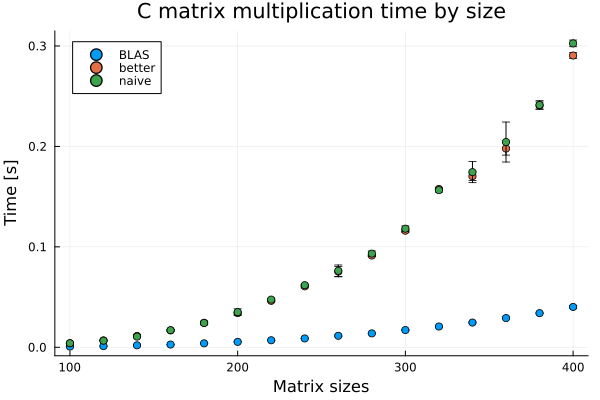

In [8]:
c_plot = @df cdf scatter(:size, :time_mean, group=:multiplication_type, yerr=:time_std, title = "C matrix multiplication time by size", ylabel="Time [s]", xlabel="Matrix sizes")

### Zadanie 3

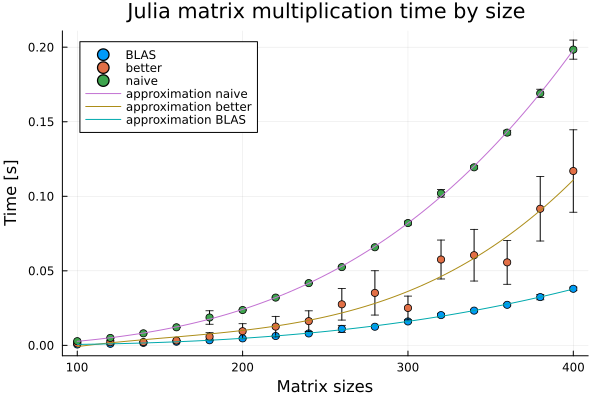

In [9]:
using Polynomials

jdf = filter(:multiplication_type => n -> n == "naive", df)
xs = jdf.size
ys = jdf.time_mean
fit_poly_3 = fit(xs, ys, 3)
plot(julia_plot)
plot!(fit_poly_3, extrema(xs)..., label="approximation naive")

jdf = filter(:multiplication_type => n -> n == "better", df)
xs = jdf.size
ys = jdf.time_mean
fit_poly_3 = fit(xs, ys, 3)
plot!(fit_poly_3, extrema(xs)..., label="approximation better")

jdf = filter(:multiplication_type => n -> n == "BLAS", df)
xs = jdf.size
ys = jdf.time_mean
fit_poly_3 = fit(xs, ys, 3)
plot!(fit_poly_3, extrema(xs)..., label="approximation BLAS")

### Zadanie 4

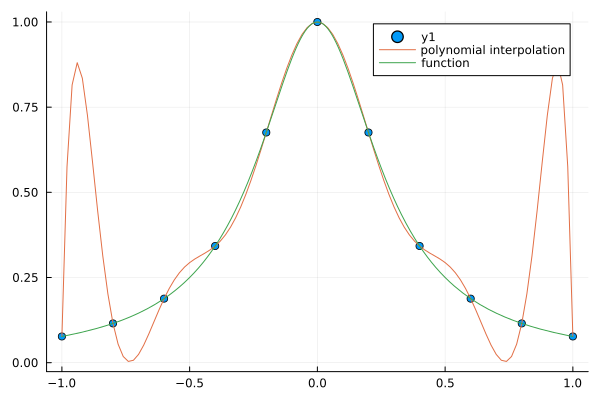

In [10]:
my_fun(x) = 1 / (1 + 12 * x^2)

xs = -1:0.2:1
ys = [my_fun(x) for x in xs]
fit_poly = fit(xs, ys, 10)

scatter(xs, ys)
plot!(fit_poly, extrema(xs)..., label="polynomial interpolation")
plot!(my_fun, extrema(xs)..., label="function")

In [11]:
n = 11
cheb_nodes = [cos(((2*k - 1) / (2*n)) * pi) for k in n:-1:1]

# cheb_poly = ChebyshevInterpolator(my_fun, cheb_nodes)
scatter(cheb_nodes, [my_fun(node) for node in cheb_nodes])
fit_cheb = fit(cheb_nodes, [my_fun(node) for node in cheb_nodes])
plot!(fit_cheb, extrema(cheb_nodes)..., label="Chebyshev interpolation")
plot!(my_fun, extrema(xs)..., label="function")
cheb_nodes

11-element Vector{Float64}:
 -0.9898214418809327
 -0.9096319953545184
 -0.7557495743542582
 -0.5406408174555972
 -0.28173255684142967
  6.123233995736766e-17
  0.2817325568414296
  0.5406408174555977
  0.7557495743542584
  0.9096319953545184
  0.9898214418809327

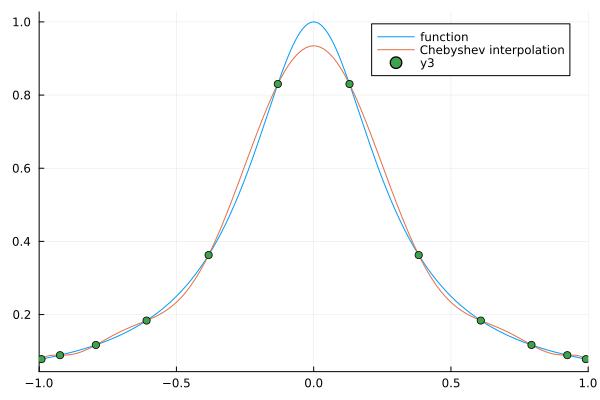

In [12]:
cheb_nodes = Polynomials.roots(ChebyshevT(push!([0 for _ in 1:12], 1)))
cheb_polys = [ChebyshevT(push!([0 for _ in 1:k], 1)) for k in 0:n]
    
coefficients = [(1 / (n + 1)) * sum([my_fun(cheb_nodes[k+1]) * cheb_polys[1](cheb_nodes[k+1]) for k in 0:n])]
append!(coefficients, [(2 / (n + 1)) * sum([my_fun(cheb_nodes[k+1]) * cheb_polys[i+1](cheb_nodes[k+1]) for k in 0:n]) for i in 1:n])

t2 = ChebyshevT(coefficients)

plot(my_fun, extrema(xs)..., label="function")
plot!(t2, label="Chebyshev interpolation")
scatter!(cheb_nodes, [my_fun(node) for node in cheb_nodes])

### Zadanie 5

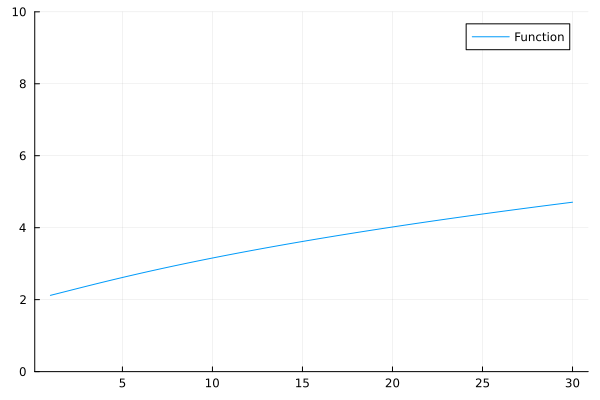

In [13]:
F(x) = (7 + (1 + x)^(4//3))^(1//3)
xsf = 1:0.001:30
ysf = [F(x) for x in xsf]
plot(xsf, ysf, ylimits = (0, 10), label="Function")

In [26]:
# using Pkg;
# Pkg.add("TaylorSeries")
using TaylorSeries

t1 = Taylor1(Float64, 4)
myfun_taylor = F(t1)
ysf_taylor = [myfun_taylor(x) for x in xsf]
plot!(xsf, ysf_taylor, label="Taylor approximation")

myfun_t_pol = Polynomial(myfun_taylor.coeffs)
myfun_pade = Polynomials.PolyCompat.PadeApproximation.Pade(myfun_t_pol, 2, 2)
ysf_pade = [myfun_pade(x) for x in xsf]

plot!(xsf, ysf_pade, label="Pade approximation")

In [ ]:
# xsf = -1.0001:0.001:30
ysf = [F(x) for x in xsf]
plot(xsf, ysf)